In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
from utils import *
from plots import plot_locality_hist, plot_locality_kde

# Read results from ../results/locality, output data to ../out/figures/locality
BASE_DATA_PATH = os.path.join("..", "out", "locality")
OUTPUT_FOLDER = os.path.join("..", "out", "figures", "locality")
print("Reading data from: ", BASE_DATA_PATH)
print("Outputting plots to: ", OUTPUT_FOLDER)
set_default_style()

Reading data from:  ../out/locality
Outputting plots to:  ../out/figures/locality


# Visualizaciones de localidad con histogramas
Idea: dada una búsqueda sobre un centro $p_i$ que encuentra un número de puntos en el vecindario $p_j$, construimos un histograma con las distancias $|i-j|$, y lo ponemos en un dataset (distancia, count).

Las búsquedas fueron $k$-NN y acumulando sobre todos los puntos de la nube como centro. Para radio fijo se encuentran resultados similares, solo que con la dificultad añadida de tener que ajustar el radio para compensar la densidad del dataset.



## Ajustes para poder visualizar el histograma

Tuve que hacer algunos ajustes para que se viera bien el efecto de la distancia en la localidad de la nube:

- En primer lugar comprimí el histograma en bins y tomé la distancia más baja para representar el bin, por ejemplo si $bin\_size=2$, se convierte (dist=1, count = 100 / dist=2, count = 200 / dist=3, count=300 / dist=4, count=75) en (dist=1, count=300 / dist=3, count=375), ver función `bin_datasets`.

- En segundo lugar, para que los outliers no afectaran mucho a la representación, añadí un límite superior $x_{max}$ (`max_dist` en el código) a las distancias. El límite se toma como el máximo de los límites $x_{max,ord}$ de cada reordenación (none, mort, hilb) bajo el que se encuentran el $p\%$ de los datos, ver función `compute_max_dists`.

Los parámetros que tomé fueron $k = 50$, $bin\_size = 100$ y $p = 0.99$. Así ya salen gráficas, sin embargo, encontré algo bastante curioso con esto. El problema es que los puntos encontrados en distancias bajas del punto de búsqueda son la gran mayoría, y en muchos datasets el orden original es bastante bueno en el sentido de que existen más datos en el rango bajo. 

Sin embargo ese rango bajo es ignorable para el rendimiento ya que debería generar muy pocos fallos caché comparando con el rango de distancias altas. Por lo tanto, también añadí un límite inferior $x_{min}$ al gráfico (`min_dist` en el código), que puse a $1000$ de momento. 

Una vez hecho esto, se nota en muchos datasets como al no reordenar la nube existe una gran cantidad de picos aislados en distancias alejadas de memoria, lo cuál interpreto como una versión suavizada de los picos extremos que se encontrarían al hacer esto para una nube regular de puntos enteros $(i,j,k)$ creada con un triple bucle sencillo.

### KDE-plot

Quizás menos informativo que el histograma ya que no se ven los picos, pero se ve rápidamente como la distribución de las distancias (dentro de los límites $x_{min}, x_{max}$) mejora al reordenar la nube. 

También añadí el cálculo rápido de la media y la desviación típica de las distancias, con el dataset original sin bins y sin límites.

In [7]:
def compute_locality_stats(datasets):
    stats = []
    for encoder, df in datasets.items():
        # Compute weighted mean and std dev
        mean = np.average(df["distance"], weights=df["count"])
        variance = np.average((df["distance"] - mean)**2, weights=df["count"])
        std_dev = np.sqrt(variance)

        stats.append({
            "Encoder": encoder,
            "Weighted Mean": mean,
            "Weighted Std Dev": std_dev
        })

    stats_df = pd.DataFrame(stats)
    return stats_df.to_string(index=False)

In [8]:
def bin_datasets(dfs, bin_size):
    binned_dfs = {}
    for key, df in dfs.items():
        df_copy = df.copy()
        df_copy["distance"] = (df_copy["distance"] // bin_size) * bin_size
        binned_dfs[key] = df_copy.groupby("distance", as_index=False)["count"].sum()
    return binned_dfs

def compute_max_dists(dfs, percent=0.99):
    max_dists = {}
    for encoder, df in dfs.items():
        df_sorted = df.sort_values("distance")
        total_count = df_sorted["count"].sum()
        cumulative = df_sorted["count"].cumsum()
        limit_row = df_sorted[cumulative >= percent * total_count].iloc[0]
        max_dists[encoder] = limit_row["distance"]
    return max_dists

In [9]:
def show_visualizations(cloud, min_dist = 1000, percent_plotted=0.99, bin_size=10, use_log=False, kde=False):
    dfs = get_all_locality_files(BASE_DATA_PATH, cloud)
    original_dfs = {}
    for name, df in dfs.items():
        original_dfs[name] = df.copy()
    
    # Bin
    if bin_size > 1:
        dfs = bin_datasets(dfs, bin_size)

    # Compute right limits for each encoding at percent_plotted of distances seen
    per_datase_max_dists = compute_max_dists(dfs, percent=percent_plotted)
    print(f"Distance limits for {percent_plotted*100}% of counts per dataset:")
    for encoder, l in per_datase_max_dists.items():
        print(f"  {encoder}: {l}")

    # Use the maximum of all as final right limit for plotting
    max_dist = max(per_datase_max_dists.values())
    print(f"Using final plot limit = {max_dist}")

    # Filter the dfs in the range
    for key, df in dfs.items():
        dfs[key] = df[(df["distance"] >= min_dist) & (df["distance"] <= max_dist)]
    hist = plot_locality_hist(dfs, bin_size, min_dist, max_dist, use_log)
    if kde:
        plot_locality_kde(dfs, min_dist, max_dist)
    
    print(compute_locality_stats(original_dfs))
    return hist

## Lille_0 (10M) y Paris_Luxembourg_7 (10M)
Dos de las tiles de paris_lille, aquí ya se empiezan a ver los picos en distancias alejadas que contribuyen a los fallos caché cuando no reordenas la nube.

../out/locality
Loading latest file: ../out/locality/Lille_0/Lille_0-none-locality.csv
Loading latest file: ../out/locality/Lille_0/Lille_0-mort-locality.csv
Loading latest file: ../out/locality/Lille_0/Lille_0-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 496900
  mort: 199500
  hilb: 201100
Using final plot limit = 496900
Encoder  Weighted Mean  Weighted Std Dev
   none  105221.769568     110477.727581
   mort   19354.499645     231864.932565
   hilb   15417.568178     200409.004055


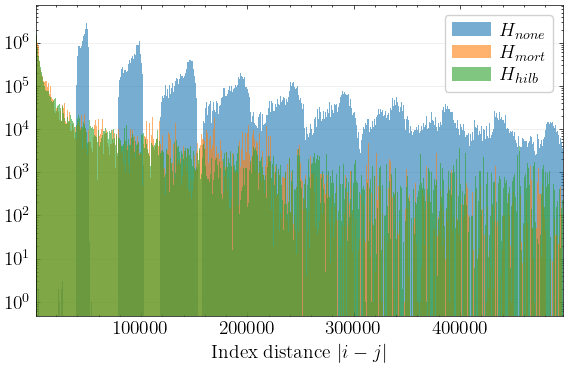

In [10]:
hist = show_visualizations("Lille_0", 1000, 0.99, 100, use_log=True)
output_fig(hist, OUTPUT_FOLDER, "Lille_0")
hist

In [11]:
# show_visualizations("Paris_Luxembourg_6", 1000, 0.99, 100)

## Lille full (120M)
El archivo de esta nube está creado con `lasmerge` de cada una de las partes `Lille_xx`. Imagino que los saltos grandes que se ven serán justo por eso, en las partes mal pegadas habrá una distancia enorme entre los puntos. Por lo que reordenar al juntar varias tiles de un dataset es muy importante.

Aquí uso $bin\_size = 1000$ y escala logarítmica en el eje Y del histograma para poder visualizar mejor

In [12]:
# show_visualizations("Lille", 1000, 0.99, 1000, use_log=True)

## Paris_Luxembourg full (50M)

Aquí no observé los picos como en el de `Lille`, el resultado es parecido al de las tiles por separado

In [13]:
# show_visualizations("Paris_Luxembourg", 1000, 0.99, 1000)

## Datasets Semantic3D

- bildstein_station1_xyz_intensity_rgb (29M puntos)
- sg27_station8_intensity_rgb (42M puntos)
- station1_xyz_intensity_rgb (50M puntos)

Tienen resultados variados, los de bildstein y sg27 no mejoran demasiado, mientras que el de station1 es mucho mejor tras reordenar.

In [14]:
# show_visualizations("bildstein_station1_xyz_intensity_rgb", 1000, 0.99, 100)

../out/locality
Loading latest file: ../out/locality/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-none-locality.csv
Loading latest file: ../out/locality/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-mort-locality.csv
Loading latest file: ../out/locality/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-hilb-locality.csv
Distance limits for 99.5% of counts per dataset:
  none: 631200
  mort: 111200
  hilb: 112700
Using final plot limit = 631200
Encoder  Weighted Mean  Weighted Std Dev
   none  131988.334673      4.551451e+06
   mort   40173.943437      2.261239e+06
   hilb   42902.655783      2.767124e+06


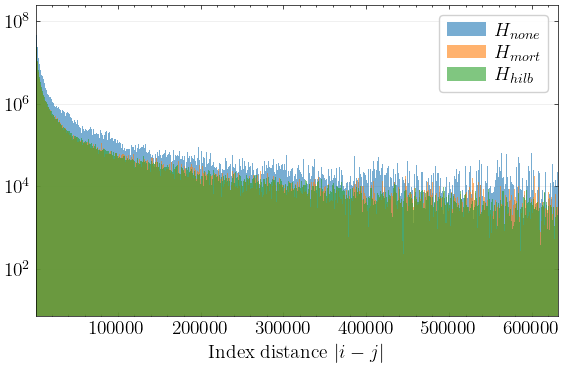

In [15]:
hist = show_visualizations("sg27_station8_intensity_rgb", 1000, 0.995, 100, use_log=True)
output_fig(hist, OUTPUT_FOLDER, "sg27")
hist

../out/locality
Loading latest file: ../out/locality/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-none-locality.csv
Loading latest file: ../out/locality/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-mort-locality.csv
Loading latest file: ../out/locality/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 33673000
  mort: 176000
  hilb: 165000
Using final plot limit = 33673000
Encoder  Weighted Mean  Weighted Std Dev
   none   4.696816e+06      1.011376e+07
   mort   2.547942e+04      5.731624e+05
   hilb   3.115047e+04      7.136155e+05


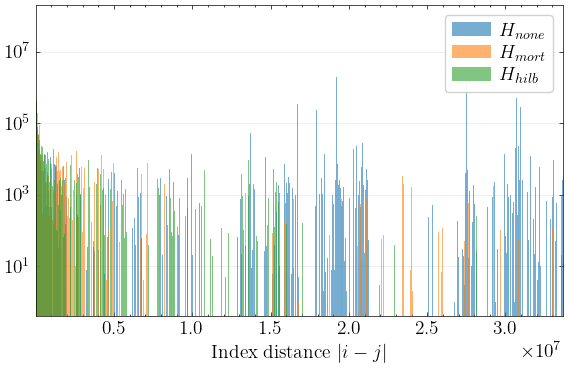

In [16]:
hist = show_visualizations("station1_xyz_intensity_rgb", 1000, 0.99, 1000, use_log=True)
output_fig(hist, OUTPUT_FOLDER, "station1")
hist

## DALES

Dibujados en escala logarítmica porque se distingue mucho mejor. El hecho de que sea LiDAR aéreo imagino que influye a la mala localidad original.

../out/locality
Loading latest file: ../out/locality/5080_54400/5080_54400-none-locality.csv
Loading latest file: ../out/locality/5080_54400/5080_54400-mort-locality.csv
Loading latest file: ../out/locality/5080_54400/5080_54400-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 11028500
  mort: 601500
  hilb: 494500
Using final plot limit = 11028500
Encoder  Weighted Mean  Weighted Std Dev
   none   4.002768e+06      2.919510e+06
   mort   3.844322e+04      4.138449e+05
   hilb   2.346791e+04      2.398460e+05


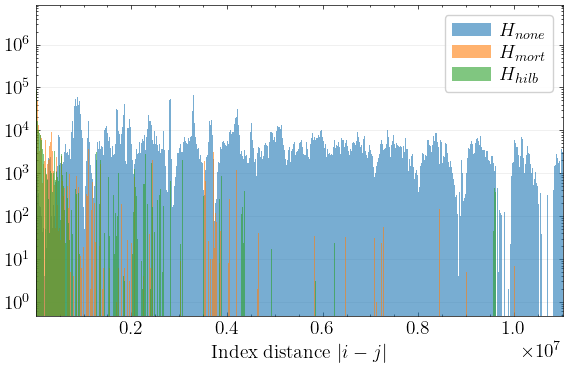

In [17]:
hist = show_visualizations("5080_54400", 1000, 0.99, 100, use_log = True)
output_fig(hist, OUTPUT_FOLDER, "5080_54400")
hist

In [18]:
# show_visualizations("5140_54390", 1000, 0.99, 100, use_log = True)

In [19]:
# show_visualizations("5150_54325", 1000, 0.99, 100, use_log = True)